In [202]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import pickle
import time

In [203]:
RATE_LIMIT=3
SLEEP_TIME=1
WAIT_TIME=3
MAX_PY=15  #max players recorded is 15 slot 5 is used to record score instead
SCORE_LOC=0
link_count=0
link_wait=0
FORMAT='lxml'
site_header = "https://www.basketball-reference.com"

In [204]:
players={"None":{
    "name":"Reserves",
    "DOB":"1900",
    "drafted":1900,
    "gp":0,
    "team":"None",
    "link": ""}}
game_data=[]
playoff_data=[]

In [490]:
#pickle.dump(game_data,open("game_data.p","wb"))
#pickle.dump(playoff_data,open("playoff_data.p","wb"))   
#pickle.dump(players,open("players.p","wb"))   

#game_data=pickle.load(open("game_data.p","rb"))
#playoff_data=pickle.load(open('playoff_data.p','rb'))
#players=pickle.load(open("players.p","rb"))

First find line score in the page. This will produce the the first set of values.

In [205]:
def  get_response(link):    
    '''
    use request to get a page. If not ready, keep increase wait time 
    '''
    global link_wait,link_count
    link_count+=1
    if (link_count % RATE_LIMIT) == 0:
        time.sleep(SLEEP_TIME)
        print(link_count)
    if link[0] == '/':
        link=site_header + link
    #with open('test.html') as page:
    #    return page.read()
#def get(link):    
    response = requests.get(link)
    while response.status_code != 200:
        link_wait += WAIT_TIME
        time.sleep(link_wait)        
        print("Failure in opening {}, waiting {} s".format(link,link_wait))
        response = requests.get(link)
    return response.text

In [276]:
def parse_month_sch(month_soup,game_data,work):
#month_soup=sch_soup
#for k in range(0,1):  
    '''
    Parse a month worth of regular season box scores 
    If work is True, process all the lines until 
    playoff line is seen. 
    If work is False, process nothing until the playoff
    line is seen. Then start processing all lines after.
    This playoff line is only seen in April, as in
    May/June, the entire month is playoff so the line is 
    not seen.     
    '''
    
    non_playoff = True     
    # Set counter to negative to skip the first n lines if needed
    counter=0
    sch_div=month_soup.find('div',id='all_schedule')
    title=sch_div.find('h2').text
    print("Start of {}".format(title))
    month_div=sch_div.findNext('div',id='div_schedule').find('tbody')
    tr_tag=month_div.find('tr')

    while tr_tag :
        if (tr_tag.text == "Playoffs"): 
            non_playoff=False
            # the line with text "playoff" has no content. Seek next line
            tr_tag=tr_tag.findNext('tr')
            
        if (non_playoff == work):
            box_tag=tr_tag.find('td',text="Box Score")        
            box_link = box_tag.find('a').get('href')
            print(box_link.split('/')[-1])
            counter+=1
            if counter > 0:
                parse_box_score(box_link,game_data)           
            
        tr_tag=tr_tag.findNext('tr')
    print("{} done".format(title))


In [286]:
def parse_season_sch(link,game_data,playoff):
#with open('schedule.html') as page:
    #test_html = page.read()
    #sch_soup = BeautifulSoup(test_html, FORMAT)
    '''
    Parse the box score of a whole regular season season
    and save the output game data
    playoff months in May and June are skipped
    '''
        
    sch_soup = BeautifulSoup(get_response(link), FORMAT)
    sch_filter = sch_soup.find('div',id='content').find('div',class_='filter')
 
    for item in sch_filter.find_all('div'): 
        
        text=item.get('class')
        #If playoff is false, process up to April, skip the May and June schedule.
        #otherwise, only process starting from April. Half the games in April is
        #regular season, half is playoff. Send the work flag to tell if shall
        #process the playoff part, or the regular season part

        if text and ("current" in text):
            #This is October
            if playoff:
                continue
            parse_month_sch(sch_soup,game_data,True)            
        elif item.text.strip() in ['May','June']: 
            if not playoff:
                continue
            n_link=item.find('a').get('href')
            n_soup = BeautifulSoup(get_response(n_link), FORMAT)            
            parse_month_sch(n_soup,game_data,True)
        elif item.text.strip() == 'April':
            n_link=item.find('a').get('href')
            n_soup = BeautifulSoup(get_response(n_link), FORMAT)            
            parse_month_sch(n_soup,game_data,not playoff)
        elif not playoff:  
            n_link=item.find('a').get('href')
            n_soup = BeautifulSoup(get_response(n_link), FORMAT)            
            parse_month_sch(n_soup,game_data,True)
    
    if playoff:
        filename="playoff_data.p"
    else:
        filename='game_data.p'

    pickle.dump(game_data,open(filename,"wb"))
    pickle.dump(players,open("players.p","wb"))              

game_data

In [208]:
def find_box(df,soup,team,date):
    p_list=list(range(0,15))
    for i in range(1,5):
        find_q_box(df,p_list,soup,team,date,i)
    return p_list

In [209]:
def parse_box_score(link,game_data):
#for j in range(0,1):    
    '''
    parse a box score of a game
    Parse general info first, then 4 quarters of the visiting team
    box score, then 4 quarters of home team box score
    '''    
    soup = BeautifulSoup(get_response(link), FORMAT)

    #soup = BeautifulSoup(response.text, FORMAT)    
    #find the date and teams from the title.
    title = soup.find("title").text.split('Box Score')
    teams=title[0].split(' at ')
    visit=teams[0]
    home =teams[1]
    date = pd.to_datetime(title[1].split('|')[0].replace(',',''))

    #team shorthand
    teamsymbol=soup.find('div', class_='scorebox').find_all('strong')
    team_v = teamsymbol[0].find('a').get('href').split('/')[-2]
    team_h = teamsymbol[1].find('a').get('href').split('/')[-2]

    #line score per quarter.
    #line_table = soup.find('div', id="div_line_score",class_='table_container is_setup').find('tbody').find_all('tr')
    #row1 is visiting team, row2 2 is home team
    #line_v= pd.Series([ int(td.text) for td in line_table[0].find_all('td')])
    #line_h= pd.Series([ int(td.text) for td in line_table[1].find_all('td')])
    #line_diff=line_h-line_v
    seasonv=soup.find('div',id='box-{}-game-basic_sh'.format(team_v))
    games=seasonv.find('h2').text.split('(')[1].split(')')[0].split('-')
    gamev_season = int(games[0])+int(games[1])
    
    season=soup.find('div',id='box-{}-game-basic_sh'.format(team_h))
    games=season.find('h2').text.split('(')[1].split(')')[0].split('-')
    gameh_season = int(games[0])+int(games[1])
    #find q1 score box for visiting team.

    #For each player, first 4 rows of MAX_PY each is to record playing time. Last
    #row record games played in season. Player/column 0 record game score. 
    df=[0]*5*MAX_PY
    p_list=find_box(df,soup,team_v,date)
    df1=[0]*5*MAX_PY
    p_list1=find_box(df1,soup,team_h,date)
    
    headers=['home','visit','date','player_v','player_h','data']
    #for column 0, first 4 rows are home - visit points scored, 
    #last row is games in season 
    df[4*MAX_PY+SCORE_LOC]=gamev_season
    df1[4*MAX_PY+SCORE_LOC]=gameh_season
    df.extend(df1)
   
    datapoint=dict(zip(headers, [team_h, team_v, date,p_list,p_list1,df]))
    game_data.append(datapoint)
    #print(home,visit,date)
    #print(team_h,team_v, gameh_season)

In [210]:
#team=team_v
#quarter=1

def find_q_box(df,p_list,soup,team,date,quarter):
#for j in range(0,1):
    '''
    find box score for a particular quarter for a team
    and add to data frame
    '''
#    p_list=list(range(0,14))
#    df=np.zeros([1,14])
    table = soup.find('table',id='box-{}-q{}-basic'.format(team,quarter))
    #team score in footer

    offset=MAX_PY*(quarter-1)
    tbody=table.find('tbody')
    for index,t_row in enumerate(tbody.find_all('tr')):
        player=t_row.select('th[data-stat="player"]')
        name = player[0].text 
        if name != 'Reserves':
            #rows with data-stat="reason" has no other valid data
            p_reason = t_row.select('td[data-stat="reason"]')
            if not len(p_reason):              
                p_time = t_row.select('td[data-stat="mp"]')[0].text.split(":")
                playing_time=int(p_time[0])*60+int(p_time[1])                
                if index <5:
                    i=index+1
                else:
                    i=index
                
                df[offset+i]=playing_time 
                
                if not df[4*MAX_PY+i]:   #played in this game 
                    games_played=0
                    p_id = player[0].get('data-append-csv')
                    p_list[i-1]=p_id
                #
                #if team not in teams:
                #    #add to team list.
                #    teams[team]={"name":team}

                    if p_id not in players:
                    #Add to player list, query link to find player age.
                    #other info, etc.
                        p_link=player[0].find('a').get('href')
                        date_of_birth,draft_year,games_played=parse_player(p_link,date)                            
                        games_played=games_played+1
                        players[p_id]={"name":name,
                                "DOB":date_of_birth,
                                "Drafted":draft_year,
                                "gp":games_played,        
                                "team":team,
                                "link":p_link}
                    else:
                        games_played = players[p_id]['gp']+1
                        players[p_id]['gp']=games_played    
                    df[4*MAX_PY+i]=games_played
                    
    score=table.findNext('tfoot').select('td[data-stat="pts"]')                    
    df[offset+SCORE_LOC]= int(score[0].text)                                  
                    
#            print(q1_id,q1_name,q1_time,q1_link,years)
#    return 

In [219]:
def parse_player(link,date):
    p_soup=BeautifulSoup(get_response(link),FORMAT)
    dob='1900'
    dob_tag=p_soup.find('span',id='necro-birth')
    if dob_tag:
        dob=dob_tag.get('data-birth')
    draft_year=1900
    #year drafted
    bio=p_soup.select('div[itemtype = "https://schema.org/Person"]')
    for p in bio[0].find_all('p'):
        s=p.find('strong')
        if (s and ("Draft:" in s.text)):
            draft_year = int(p.find_all('a')[1].text.split()[0])
            break
        elif   (s and ("Debut:" in s.text)):
            draft_year = int(p.find('a').text.split(',')[1])
            break
            
    gp=0            
    stat=p_soup.find('div',id='div_per_game').find('tbody')
    for row in stat.find_all('tr'):
        row_year_tag=row.get('id')
        if (row_year_tag):
            row_year=row_year_tag.split('.')[1]
            if date.year >= int(row_year):
                gp+=int(row.select('td[data-stat="g"]')[0].text)    
                
    s=p_soup.find('div',id='div_playoffs_per_game')
    if s:
        stat=s.find('tbody')
        for row in stat.find_all('tr'):
            row_year_tag=row.get('id')
            if (row_year_tag):
                row_year=row_year_tag.split('.')[1]
                if date.year >= int(row_year):
                    gp+=int(row.select('td[data-stat="g"]')[0].text)    
                 
    return dob,draft_year,gp

In [480]:
#due to how counting the games played in season, list need to start from earlier
#years to later years.
links=['/leagues/NBA_2017_games.html',
       '/leagues/NBA_2019_games.html',
       '/leagues/NBA_2018_games.html'     
        ]

In [388]:
#In each season, do regular season, followed by post season
#The year needs to increase, since the game played in player directory
#includes the games played up to that year. Going back would cause the
#games played to be incorrectly counted.
#To process a previous year requires the GP in player to be set to 0 again, so every
#player page have to be scrapped again to start the games played value correctly.
for link in links:
    parse_season_sch(link,game_data,False)
    parse_season_sch(link,playoff_data,True)

Start of October Schedule
201710170CLE.html
1812
1815
201710170GSW.html
201710180DET.html
1818
1821
201710180IND.html
1824
201710180ORL.html
1827
201710180WAS.html
1830
201710180BOS.html
1833
201710180MEM.html
1836
201710180DAL.html
1839
1842
201710180UTA.html
1845
201710180SAS.html
1848
201710180PHO.html
1851
201710180SAC.html
1854
201710190TOR.html
1857
1860
1863
201710190OKC.html
1866
201710190LAL.html
1869
1872
201710200CHO.html
1875
201710200IND.html
1878
201710200MIL.html
1881
201710200PHI.html
1884
201710200WAS.html
1887
201710200BRK.html
1890
201710200MIN.html
201710200DAL.html
1893
201710200NOP.html
201710200PHO.html
1896
201710210TOR.html
201710210CHI.html
201710210CLE.html
1899
1902
201710210HOU.html
1905
201710210MEM.html
201710210MIA.html
201710210NYK.html
1908
201710210MIL.html
201710210DEN.html
1911
201710210UTA.html
1914
201710210LAC.html
201710220BRK.html
201710220OKC.html
1917
201710220LAL.html
201710230DET.html
201710230MIA.html
1920
201710230HOU.html
201710230MIL.ht

2313
201712120SAC.html
201712130IND.html
201712130ORL.html
2316
201712130WAS.html
201712130BOS.html
2319
201712130MIA.html
201712130CHI.html
201712130NOP.html
2322
201712130PHO.html
201712130HOU.html
201712140ATL.html
2325
201712140BRK.html
201712140CLE.html
201712140MIN.html
2328
201712140GSW.html
201712150CHO.html
2331
201712150IND.html
201712150ORL.html
201712150PHI.html
2334
201712150WAS.html
201712150BOS.html
201712150TOR.html
2337
201712150MEM.html
201712150MIL.html
201712150DEN.html
2340
201712150HOU.html
201712160CHO.html
201712160CLE.html
2343
201712160NYK.html
201712160HOU.html
201712160MIA.html
2346
201712160MIN.html
201712160SAS.html
201712160MEM.html
2349
201712170TOR.html
201712170DET.html
201712170BRK.html
2352
201712170WAS.html
201712180CHO.html
201712180IND.html
2355
201712180ATL.html
201712180CHI.html
201712180HOU.html
2358
201712180MIN.html
201712180OKC.html
201712180DAL.html
2361
201712180SAS.html
201712180LAL.html
201712190PHI.html
2364
201712190WAS.html
201712190M

201802080POR.html
2751
201802080GSW.html
201802080LAL.html
2754
201802090DET.html
201802090PHI.html
201802090ATL.html
2757
201802090BOS.html
201802090HOU.html
201802090MIA.html
2760
201802090UTA.html
201802090CHI.html
201802090SAC.html
2763
201802100BRK.html
201802100ORL.html
201802100PHI.html
2766
201802100CHI.html
201802100DAL.html
201802100GSW.html
2769
201802100PHO.html
201802110CHO.html
201802110ATL.html
2772
201802110BOS.html
201802110IND.html
201802110HOU.html
2775
201802110MIN.html
201802110OKC.html
201802110POR.html
2778
201802120DET.html
201802120PHI.html
201802120BRK.html
2781
201802120CHI.html
201802120UTA.html
201802120GSW.html
2784
201802130TOR.html
201802130MIL.html
201802130MIN.html
2787
201802130OKC.html
201802130DAL.html
201802130DEN.html
2790
201802140DET.html
201802140ORL.html
2793
201802140PHI.html
201802140BRK.html
201802140NYK.html
2796
201802140BOS.html
201802140CHI.html
201802140HOU.html
2799
201802140MEM.html
201802140NOP.html
201802140UTA.html
2802
201802140P

201804110MIN.html
3186
201804110NOP.html
201804110OKC.html
201804110ORL.html
3189
201804110PHI.html
201804110LAC.html
3192
201804110POR.html
201804110SAC.html
3195
April Schedule done
Start of April Schedule
201804140GSW.html
3198
201804140TOR.html
201804140PHI.html
201804140POR.html
3201
201804150BOS.html
201804150CLE.html
201804150OKC.html
3204
201804150HOU.html
201804160PHI.html
201804160GSW.html
3207
201804170TOR.html
201804170BOS.html
201804170POR.html
3210
201804180CLE.html
201804180OKC.html
201804180HOU.html
3213
201804190MIA.html
201804190NOP.html
201804190SAS.html
3216
201804200IND.html
201804200WAS.html
201804200MIL.html
3219
201804210MIA.html
201804210NOP.html
201804210MIN.html
3222
201804210UTA.html
201804220MIL.html
201804220SAS.html
3225
201804220WAS.html
201804220IND.html
201804230MIN.html
3228
201804230UTA.html
201804240BOS.html
201804240PHI.html
3231
201804240GSW.html
201804250CLE.html
201804250TOR.html
3234
201804250HOU.html
201804250OKC.html
201804260MIL.html
3237
20

In [703]:
def add_info(j,new_list,year,pid):
    if pid == j:
        #fewer than 8 players played in this game.
        #set data to 0 instead.
        new_list.append(0)
        new_list.append(0)            
    else:            
        player=players[pid]        
        new_list.append(year-pd.to_datetime(player['DOB']).year)
        new_list.append(year-player['Drafted'])    

In [704]:
add_data=[]
for i in game_data:
    new_list=[]
    year = i['date'].year
    for j in range(0,8):
        pid = i['player_v'][j]
        add_info(j,new_list,year,pid)        
        pid = i['player_h'][j]
        add_info(j,new_list,year,pid)                
    add_data.append(new_list)
new_df=pd.DataFrame(add_data)    

In [876]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge,ElasticNet,Lasso,LassoCV, RidgeCV
#ordinary linear regression + w/ ridge regularization
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

In [496]:
df=pd.DataFrame(game_data)
data_p=pd.DataFrame(df['data'].to_list())

In [1328]:
HOME_LOC=5*MAX_PY
V_LOC = 0
GP_LOC=4*MAX_PY
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
MAX_OUT=5
#Q is quarter
q4h_score=(4-1)*MAX_PY+SCORE_LOC+HOME_LOC
q4v_score=(4-1)*MAX_PY+SCORE_LOC+V_LOC
q3h_score=(3-1)*MAX_PY+SCORE_LOC+HOME_LOC
q3v_score=(3-1)*MAX_PY+SCORE_LOC+V_LOC
q2h_score=(2-1)*MAX_PY+SCORE_LOC+HOME_LOC
q2v_score=(2-1)*MAX_PY+SCORE_LOC+V_LOC
q1h_score=SCORE_LOC+HOME_LOC
q1v_score=SCORE_LOC+V_LOC
y1d = data_p.iloc[:,q1h_score] - data_p.iloc[:,q1v_score]
y2d = data_p.iloc[:,q2h_score] - data_p.iloc[:,q2v_score]
y3d = data_p.iloc[:,q3h_score] - data_p.iloc[:,q3v_score]
y4d = data_p.iloc[:,q4h_score] - data_p.iloc[:,q4v_score]
Y=pd.concat([y1d,y2d,y3d,y4d],axis=1,ignore_index=True)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
std = StandardScaler()
std_poly=StandardScaler()

In [1184]:
def poly_reg(X_poly_tr, y_train,kfold, poly,X_val):
    lr_p=LinearRegression()
    scores = cross_val_score(lr_p, X_poly_tr, y_train, cv=kfold, scoring='neg_root_mean_squared_error')   
    print("score using neg_root_mean_squared_error is, {}\n, mean is {}, std is {}".
          format(scores,np.mean(scores),np.std(scores)))
    scores = cross_val_score(lr_p, X_poly_tr, y_train, cv=kfold)
    print("score using R2 is {}, mean is {}, std is {}".format(scores,np.mean(scores),np.std(scores)))
    lr_p.fit(X_poly_tr,y_train)
    
    # score fit model on validation data
    val_score = lr_p.score(std_poly.transform(poly.transform(X_val.values)), y_val)
   
    # report results
    print('\nValidation R^2 score was:{} with intercept {}'.format(val_score,lr_p.intercept_))
    print('Feature coefficient results:{} \n'.format(lr_p.coef_))

In [1401]:
def linear_fit(player,X,y,std,kfold,lrfit,smfit):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    std.fit(X_train.values)
    X_tr=std.transform(X_train.values)
    alpha_range = np.logspace(-2, 2, 5)
    lr = LassoCV(alphas=alpha_range,cv=kfold).fit(X_tr, y_train) #,scoring='neg_root_mean_squared_error')
    print(f"For quarter {quarter+2}, player {player}\n:")
    #print("score using neg_root_mean_squared_error is {}\n, mean is {}, std is {}".
    #      format(scores,np.mean(scores),np.std(scores)))

    train=lr.score(X_tr,y_train)
    print("score using R2 is {}".format(train))

    # score fit model on validation data
    val_score = lr.score(std.transform(X_val.values), y_val)
    lrfit.append(lr)
    #Create the sm model
    model = sm.OLS(y_train, sm.add_constant(X_tr)) 
    smfit.append(model.fit())
    return train,val_score

In [1333]:
def poly_grid(X, y,kfold,poly,lrfit):
#for j in range(0,1):
    '''
    Use LASSO to select a polynomial model
    '''
    params = { "alpha": np.logspace(-1, 2, 4)}
    
    grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, 
                        return_train_score=False)
             #               scoring='neg_root_mean_squared_error')
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)
    X_poly_train=poly.fit_transform(X_train)
    std_poly.fit(X_poly_train)
    X_poly_tr=std_poly.transform(X_poly_train)

        
    grid_est.fit(X_poly_tr, y_train)
    df = pd.DataFrame(grid_est.cv_results_)
    
    # bring out part of the column into a new column
    df["alpha"] = df.params.apply(lambda val: val["alpha"])
    plt.xlabel('log alpha')
    plt.ylabel('R^2')
    plt.plot(np.log(df.alpha), df.mean_test_score);  
    lr_r=grid_est.best_estimator_
    lr_r.fit(X_poly_tr, y_train)
    test_set_pred = lr_r.predict(std_poly.transform(poly.transform(X_val)))
    r2 = r2_score(y_val,test_set_pred)
    print("R2 for test is:",r2)
    lrfit.append(lr_r)
    plt.savefig('reg.png',dpi=150,transparent=False)
    return r2
       

In [1407]:
def linear_and_polynomial(quarter,G,train,test,test_p,lrfit,smfit,lr_p_fit,poly_list):
    poly = PolynomialFeatures(include_bias=False)
    X = G     
    for player in range(MAX_OUT-1,-1,-1):
        y = data_p.iloc[:,(quarter+1)*MAX_PY+player+1]
        train[player], test[player]=linear_fit(player,X,y, std,kfold,lrfit,smfit)
        test_p[player]=poly_grid(X,y,kfold,poly,lr_p_fit)
        y = data_p.iloc[:,HOME_LOC+(quarter+1)*MAX_PY+player+1]
        train[player+MAX_OUT], test[player+MAX_OUT]=linear_fit(player,X,y, std,kfold,lrfit,smfit)
        test_p[player+MAX_OUT]=poly_grid(X,y,kfold,poly,lr_p_fit)
    poly_list.append(poly)

In [1330]:
Q=[ [data_p.iloc[:,1:1+MAX_OUT]  ,                data_p.iloc[:,HOME_LOC+1:HOME_LOC+1+MAX_OUT]]  ,  # first quarter playing time
    [data_p.iloc[:,MAX_PY+1:MAX_PY+1+MAX_OUT],    data_p.iloc[:,HOME_LOC+MAX_PY+1:HOME_LOC+MAX_PY+1+MAX_OUT]]  ,  #second quarter playing time
    [data_p.iloc[:,2*MAX_PY+1:2*MAX_PY+1+MAX_OUT],data_p.iloc[:,HOME_LOC+2*MAX_PY+1:HOME_LOC+2*MAX_PY+1+MAX_OUT]],  # third quarter playing time
    [data_p.iloc[:,3*MAX_PY+1:3*MAX_PY+1+MAX_OUT],data_p.iloc[:,HOME_LOC+3*MAX_PY+1:HOME_LOC+3*MAX_PY+1+MAX_OUT]]]  #fourth quarter playing time

In [1141]:
#frame = [data_p.iloc[:,1:9],data_p.iloc[:,76:84],data_p.iloc[:,60:69],data_p.iloc[:,135:144]]
#frame1=new_df.iloc[:,1::2]
#frame1 = [data_p.iloc[:,col]**2 for col in [60,61,62,63,64,135,136,137,138,139] ]

#frame = [data_p.iloc[:,1:9],data_p.iloc[:,76:84],data_p.iloc[:,60],data_p.iloc[:,135]] 
#frame = [data_p.iloc[:,1:9],data_p.iloc[:,76:84],data_p.iloc[:,60:69],data_p.iloc[:,135:144]] 

#frame = [data_p.iloc[:,16:24],data_p.iloc[:,91:99],data_p.iloc[:,60:69],data_p.iloc[:,135:144]] 
#frame = [data_p.iloc[:,1:9],data_p.iloc[:,76:84],data_p.iloc[:,16:24],data_p.iloc[:,91:99]]
 
#frame = [data_p.iloc[:,31:39],data_p.iloc[:,106:114],data_p.iloc[:,60:69],data_p.iloc[:,135:144]] 
#frame = [data_p.iloc[:,col]+data_p.iloc[:,MAX_PY+col] for col in [1,2,3,4,5,6,7,8,76,77,78,79,80,81,82,83] ]
#frame = [data_p.iloc[:,col]+data_p.iloc[:,MAX_PY+col]+data_p.iloc[:,MAX_PY*2+col] for col in [1,2,3,4,5,6,7,8,76,77,78,79,80,81,82,83] ]
#frame = [data_p.iloc[:,col]+data_p.iloc[:,MAX_PY+col]+data_p.iloc[:,MAX_PY*2+col] for col in [1,2,3,4,5,6,7,8,76,77,78,79,80,81,82,83] ]
#G=pd.concat(frame, axis=1)
#X=Q4
#X=pd.concat([G,frame1,data_p.iloc[:,60:69],data_p.iloc[:,135:144]],
#            axis=1,ignore_index=True)
             
#             data_p.iloc[:,q2v_score],data_p.iloc[:,q2h_score]],
#X=pd.concat([Q4,frame1, data_p.iloc[:,q3v_score],data_p.iloc[:,q3h_score]],axis=1,ignore_index=True)
#y=data_p.iloc[:,34] 
#y=data_p.iloc[:,17]
#X=pd.concat([Q4, data_p.iloc[:,60:69],data_p.iloc[:,135:144],y1d,y2d], axis=1,ignore_index=True)
#y=y3d
#X=pd.concat([Q4, data_p.iloc[:,60:69],data_p.iloc[:,135:144],y1d,y2d,y3d], axis=1,ignore_index=True)
#y=y4d

In [1398]:
G = pd.concat([data_p.iloc[:,4*MAX_PY],data_p.iloc[:,HOME_LOC+4*MAX_PY]], axis=1)
test0=np.zeros([3,MAX_OUT*2])
test_p0=np.zeros([3,MAX_OUT*2])
train0=np.zeros([3,MAX_OUT*2])
lrfit0=[[],[],[]]
smfit0=[[],[],[]]
lr_p_fit0=[[],[],[]]
poly_list0=[]

In [1402]:
for quarter in range (0,3):
    #Add in the previous quarter playing time,
    X = pd.concat([G, Q[quarter][0], Q[quarter][1]],axis=1)
    linear_and_polynomial(quarter,X,train0[quarter],test0[quarter],
                  test_p0[quarter],lrfit0[quarter],smfit0[quarter],lr_p_fit0[quarter],poly_list0)

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5770569.243052006, tolerance: 6284.5047528166015
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62794.90618703514, tolerance: 6341.454916899618
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6167701.046177007, tolerance: 6341.454916899618
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

For quarter 2, player 4
:
score using R2 is 0.012040442869809431
For quarter 2, player 4
:
score using R2 is 0.010210949633672861
For quarter 2, player 3
:
score using R2 is 0.05639983710627994
For quarter 2, player 3
:
score using R2 is 0.05996729685594837
For quarter 2, player 2
:
score using R2 is 0.13806192596536626


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1200014.7453989796, tolerance: 4360.991820076239
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1766543.4155115038, tolerance: 4214.080938907706
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3350534.436313186, tolerance: 4168.392753429298
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8

For quarter 2, player 2
:
score using R2 is 0.16078369279588056
For quarter 2, player 1
:
score using R2 is 0.23652570694624975
For quarter 2, player 1
:
score using R2 is 0.23427979272428656
For quarter 2, player 0
:
score using R2 is 0.30693153596712774
For quarter 2, player 0
:
score using R2 is 0.3138114561935246
For quarter 3, player 4
:
score using R2 is 0.019373675155464287


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471450.4051280543, tolerance: 3630.8700958915706
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 990182.4058619551, tolerance: 3554.680492587886
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 963999.9580678232, tolerance: 3729.418109398817
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

For quarter 3, player 4
:
score using R2 is 0.02192026671320324
For quarter 3, player 3
:
score using R2 is 0.029921645045048684
For quarter 3, player 3
:
score using R2 is 0.025681492837555275
For quarter 3, player 2
:
score using R2 is 0.06364435416568293
For quarter 3, player 2
:
score using R2 is 0.0535182884713894
For quarter 3, player 1
:
score using R2 is 0.06363622574283767


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3386472.8547859415, tolerance: 4219.862101270111
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3471417.4461886734, tolerance: 3879.1524041507832
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519339.06683729216, tolerance: 3817.6093713680634
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python

For quarter 3, player 1
:
score using R2 is 0.06004928431150702
For quarter 3, player 0
:
score using R2 is 0.07504279079650089
For quarter 3, player 0
:
score using R2 is 0.0678826531575234
For quarter 4, player 4
:
score using R2 is 0.022006608272808093
For quarter 4, player 4
:
score using R2 is 0.022042819990529927
For quarter 4, player 3
:
score using R2 is 0.06686172628617437
For quarter 4, player 3
:
score using R2 is 0.07498514086734909
For quarter 4, player 2
:
score using R2 is 0.1104029772406605
For quarter 4, player 2
:
score using R2 is 0.13429979994909824
For quarter 4, player 1
:
score using R2 is 0.15200771129249657


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115791.94575275481, tolerance: 8216.836839627449
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3899115.7229405567, tolerance: 8027.00315850973
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7721986.832221486, tolerance: 8440.919237950015
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

For quarter 4, player 1
:
score using R2 is 0.14270802779898972
For quarter 4, player 0
:
score using R2 is 0.14634364673011535
For quarter 4, player 0
:
score using R2 is 0.14116013731530497


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 818821.4718086421, tolerance: 8405.08037695892
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 388222.29372766614, tolerance: 8220.674826005927
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2594674.376570925, tolerance: 8268.182361388652
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/s

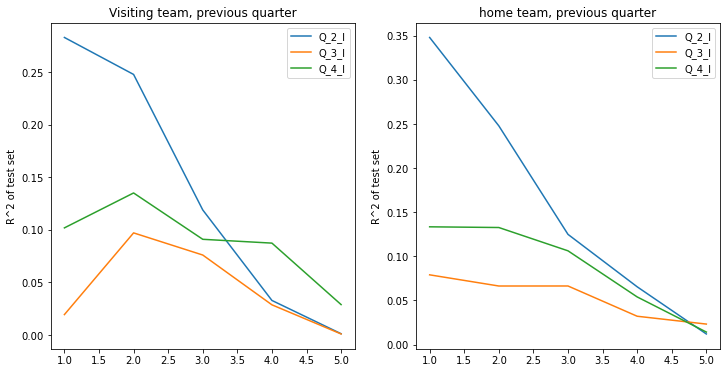

In [1403]:
plt.figure(figsize=([12,6]))
plt.subplot(1,2,1)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test0[i-2][0:MAX_OUT],label='Q_{}_l'.format(i))
plt.ylabel('R^2 of test set')
plt.title("Visiting team, previous quarter")
plt.legend()
plt.subplot(1,2,2)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test0[i-2][MAX_OUT:MAX_OUT*2],label='Q_{}_l'.format(i))
plt.ylabel('R^2 of test set')
plt.title("home team, previous quarter")
plt.legend()
plt.savefig('result.png',dpi=150,transparent=False);

In [1404]:
G = pd.concat([data_p.iloc[:,60],data_p.iloc[:,135]], axis=1)
test=np.zeros([3,MAX_OUT*2])
test_p=np.zeros([3,MAX_OUT*2])
train=np.zeros([3,MAX_OUT*2])
lrfit=[[],[],[]]
smfit=[[],[],[]]
lr_p_fit=[[],[],[]]
poly_list=[]

In [1405]:
#Start with games played 
#G = pd.concat([data_p.iloc[:,60:69],data_p.iloc[:,135:144]], axis=1)
for quarter in range (0,3):
    #Add in all the previous quarter playing time, 
    G = pd.concat([G, Q[quarter][0], Q[quarter][1]],axis=1)
    linear_and_polynomial(quarter,G,train[quarter],test[quarter],
                          test_p[quarter],lrfit[quarter],smfit[quarter],lr_p_fit[quarter],poly_list)


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5770569.243052006, tolerance: 6284.5047528166015
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62794.90618703514, tolerance: 6341.454916899618
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6167701.046177007, tolerance: 6341.454916899618
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

For quarter 2, player 4
:
score using R2 is 0.012040442869809431
For quarter 2, player 4
:
score using R2 is 0.010210949633672861
For quarter 2, player 3
:
score using R2 is 0.05639983710627994
For quarter 2, player 3
:
score using R2 is 0.05996729685594837
For quarter 2, player 2
:

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1674136.3909986354, tolerance: 3688.507060821686
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1960013.4010914117, tolerance: 3702.322588140619
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1909066.4720534608, tolerance: 3726.233158171041
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.


score using R2 is 0.13806192596536626
For quarter 2, player 2
:
score using R2 is 0.16078369279588056
For quarter 2, player 1
:
score using R2 is 0.23652570694624975
For quarter 2, player 1
:
score using R2 is 0.23427979272428656
For quarter 2, player 0
:
score using R2 is 0.30693153596712774


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2818053.058132697, tolerance: 4380.86988126694
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015452.9613173008, tolerance: 6136.776632867428
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 737750.3820793927, tolerance: 6287.368262854725
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-p

For quarter 2, player 0
:
score using R2 is 0.3138114561935246
For quarter 3, player 4
:
score using R2 is 0.08310258957706729
For quarter 3, player 4
:
score using R2 is 0.10718612975280051
For quarter 3, player 3
:
score using R2 is 0.12459823413205162
For quarter 3, player 3
:
score using R2 is 0.11685521939684285
For quarter 3, player 2
:
score using R2 is 0.1753449091434136
For quarter 3, player 2
:
score using R2 is 0.16742582487670699
For quarter 3, player 1
:
score using R2 is 0.20286162950232522
For quarter 3, player 1
:
score using R2 is 0.18607264114879496


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2749332.968886003, tolerance: 3879.1524041507832
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196532.5650968291, tolerance: 3817.6093713680634
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482446.21447876096, tolerance: 3913.3992597798483
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3

For quarter 3, player 0
:
score using R2 is 0.18709603291336707
For quarter 3, player 0
:
score using R2 is 0.20865930348208173
For quarter 4, player 4
:
score using R2 is 0.10002491935110014
For quarter 4, player 4
:
score using R2 is 0.10495831288522184


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23915.3548046723, tolerance: 2742.505035832277
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 949860.8572760634, tolerance: 2771.3124630241405
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380793.57351791486, tolerance: 2736.5937119390333
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8

For quarter 4, player 3
:
score using R2 is 0.1921746982598449
For quarter 4, player 3
:
score using R2 is 0.19920740963095984
For quarter 4, player 2
:
score using R2 is 0.2530493992935371
For quarter 4, player 2
:
score using R2 is 0.2593846949523698


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274526.7512947172, tolerance: 10546.027295552736
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8410933.043794043, tolerance: 10546.027295552736
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136144.99600975215, tolerance: 10528.825400338847
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3

For quarter 4, player 1
:
score using R2 is 0.24415099545092311
For quarter 4, player 1
:
score using R2 is 0.2557779902009205
For quarter 4, player 0
:
score using R2 is 0.1868610270169182
For quarter 4, player 0
:
score using R2 is 0.18793182420117538


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359616.47564293444, tolerance: 8961.140209995765
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3141571.1464326233, tolerance: 8970.263359678103
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1882615.5490344018, tolerance: 9099.207135182052
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.

In [1343]:
test0

array([[0.28326438, 0.24764141, 0.11687236, 0.03273153, 0.00073814,
        0.34828636, 0.24723873, 0.12457733, 0.06677769, 0.01124714],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [1346]:
test_p0

array([[0.30601808, 0.25523549, 0.12803794, 0.03292553, 0.00710246,
        0.35808889, 0.25100242, 0.13400946, 0.0633438 , 0.01440395],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

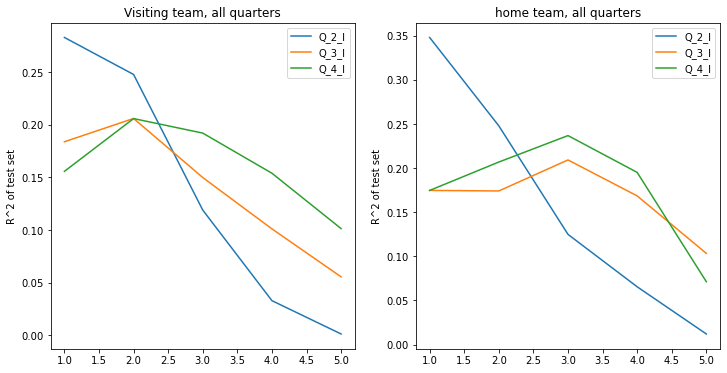

In [1412]:
plt.figure(figsize=([12,6]))
plt.subplot(1,2,1)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test[i-2][0:MAX_OUT],label='Q_{}_l'.format(i))
#    plt.plot(range(1,1+MAX_OUT),test_p[i-2][0:MAX_OUT],label='Q_{}_p'.format(i), linestyle=':')
plt.ylabel('R^2 of test set')
plt.title("Visiting team, all quarters")
plt.legend()
plt.subplot(1,2,2)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test[i-2][MAX_OUT:MAX_OUT*2],label='Q_{}_l'.format(i))
#    plt.plot(range(1,1+MAX_OUT),test_p[i-2][MAX_OUT:MAX_OUT*2],label='Q_{}_p'.format(i), linestyle=':')
plt.ylabel('R^2 of test set')
plt.title("home team, all quarters")
plt.legend()
plt.savefig('result_p.png',dpi=150,transparent=False);

In [1408]:
#Add in game experience 
G = pd.concat([data_p.iloc[:,60:60+1+MAX_OUT],data_p.iloc[:,135:135+1+MAX_OUT]], axis=1)
test2=np.zeros([3,MAX_OUT*2])
test_p2=np.zeros([3,MAX_OUT*2])
train2=np.zeros([3,MAX_OUT*2])
lrfit2=[[],[],[]]
smfit2=[[],[],[]]
lr_p_fit2=[[],[],[]]
poly_list2=[]

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5939163.2285295725, tolerance: 6284.5047528166015
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57594.80324239284, tolerance: 6341.454916899618
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6328447.18450205, tolerance: 6341.454916899618
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

For quarter 2, player 4
:
score using R2 is 0.031179761279317764


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 646930.9748362452, tolerance: 6284.5047528166015
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1466585.3646213114, tolerance: 6341.454916899618
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1498315.1998016834, tolerance: 6301.68020088908
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/

R2 for test is: 0.025717432351738068
For quarter 2, player 4
:
score using R2 is 0.022254174777481595


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5448277.088888489, tolerance: 6511.594655993225
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3498925.948968433, tolerance: 6488.5857492587875
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4388921.039952926, tolerance: 6470.6310064775635
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8

R2 for test is: 0.019242102933789806
For quarter 2, player 3
:
score using R2 is 0.05871989286444601


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99667.57561194152, tolerance: 4388.226183566286
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4145382.5064865127, tolerance: 4388.226183566286
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3032104.235947624, tolerance: 4223.411315205423
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.03375851791290285
For quarter 2, player 3
:
score using R2 is 0.07590486267506558


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521684.5050270483, tolerance: 4360.991820076239
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 859297.3078093007, tolerance: 4214.080938907706
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3051025.0462406017, tolerance: 4168.392753429298
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.06065754817189628
For quarter 2, player 2
:
score using R2 is 0.1459146422630354


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1847818.3707523644, tolerance: 3688.507060821686
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2239350.5325532705, tolerance: 3702.322588140619
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2503256.298897203, tolerance: 3726.233158171041
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8

R2 for test is: 0.12098168162240386
For quarter 2, player 2
:
score using R2 is 0.1700498049507645


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5035.852536607534, tolerance: 3610.419823210504
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2962762.2044887543, tolerance: 3610.419823210504
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1636895.2538138032, tolerance: 3494.7910617534935
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.

R2 for test is: 0.13188917300263592
For quarter 2, player 1
:
score using R2 is 0.24658950824595682


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1035142.4962838963, tolerance: 3447.7088244811507
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116868.60652782023, tolerance: 3395.787954849641
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2469129.4417482726, tolerance: 3456.451492972059
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3

R2 for test is: 0.2556623602313439
For quarter 2, player 1
:
score using R2 is 0.24502211143248764


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 631269.2468941398, tolerance: 3263.4516626005934
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236958.0673161596, tolerance: 3091.443839458087
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194594.1374916993, tolerance: 3136.03465508044
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/s

R2 for test is: 0.2493509994936377
For quarter 2, player 0
:
score using R2 is 0.3181517821866008


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257883.03085921705, tolerance: 3630.8700958915706
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 823177.3578020744, tolerance: 3554.680492587886
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 931476.8800400309, tolerance: 3729.418109398817
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8

R2 for test is: 0.30576349046564466
For quarter 2, player 0
:
score using R2 is 0.3253524506503265


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2286973.6570522115, tolerance: 3512.843005675561
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1200851.9984893613, tolerance: 3501.9781367217283
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5756.895863160491, tolerance: 3435.350535139712
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.

R2 for test is: 0.35724357097400383
For quarter 3, player 4
:
score using R2 is 0.09064356743981083


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 838495.7926757634, tolerance: 6136.776632867428
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 812447.7990401015, tolerance: 6287.368262854725
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2986321.8066651523, tolerance: 6375.000066765453
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.054788483914833486
For quarter 3, player 4
:
score using R2 is 0.1138992230428274


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36694.820055641234, tolerance: 6331.205614061838
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5665978.935246233, tolerance: 6331.205614061838
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201799.66446651518, tolerance: 6201.621739855993
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8

R2 for test is: 0.10521344638467645
For quarter 3, player 3
:
score using R2 is 0.12775534719991377


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3791439.038193647, tolerance: 4396.6647698432835
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 935384.7845374234, tolerance: 4190.93202041508
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2056139.7193915136, tolerance: 4411.302863844198
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.10832575951175338
For quarter 3, player 3
:
score using R2 is 0.12037544004233791


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1556489.0589184463, tolerance: 4127.177720542144
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 982941.862386331, tolerance: 4207.045862854723
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3846630.6681189016, tolerance: 4229.096670491109
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.16147636624738426
For quarter 3, player 2
:
score using R2 is 0.18031840159820278


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3190629.903005846, tolerance: 3879.1524041507832
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 575934.0590837672, tolerance: 3817.6093713680634
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1166837.2503535226, tolerance: 3913.3992597798483
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3

R2 for test is: 0.151902811178113
For quarter 3, player 2
:
score using R2 is 0.17183317916440188


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81345.68436470255, tolerance: 3904.7042089792462
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3303292.781964276, tolerance: 3904.7042089792462
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13219.148602999747, tolerance: 3993.8203900889453
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3

R2 for test is: 0.19413347858456642
For quarter 3, player 1
:
score using R2 is 0.20599293274321795


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 928083.6010989174, tolerance: 3495.965411266411
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2054937.2750800215, tolerance: 3488.3508969080913
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7402.94456615299, tolerance: 3376.483773920408
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.2019692663078977
For quarter 3, player 1
:
score using R2 is 0.19312688139708445


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48262.69395772368, tolerance: 3214.991115713682
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466747.4619385898, tolerance: 3206.9168305802636
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386783.78779182956, tolerance: 3211.941547502119
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8

R2 for test is: 0.18383701738605507
For quarter 3, player 0
:
score using R2 is 0.19417826567790397


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 848735.9884741679, tolerance: 2979.430715713679
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71863.33918648213, tolerance: 2906.9394008471
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1336943.539194908, tolerance: 2991.846656096529
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/sit

R2 for test is: 0.17990566503543037
For quarter 3, player 0
:
score using R2 is 0.2144917714731316


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 841074.1829179376, tolerance: 2771.3124630241405
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192170.9967543222, tolerance: 2736.5937119390333
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1140058.6722724345, tolerance: 2808.172085901777
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.

R2 for test is: 0.1709653634434395
For quarter 4, player 4
:
score using R2 is 0.10697724493039618


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3344177.41243957, tolerance: 8291.41358398983
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4451135.843934506, tolerance: 8138.4121880559005
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5678212.657142349, tolerance: 8387.154326545311
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/si

R2 for test is: 0.12239184878762832
For quarter 4, player 4
:
score using R2 is 0.11298698246432692


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5830389.191759311, tolerance: 8440.919237950015
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47887.49005948007, tolerance: 8358.327568064384
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28014.805494710803, tolerance: 8304.241344496193
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.0783367028571853
For quarter 4, player 3
:
score using R2 is 0.20586108668615133


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276467.7414204329, tolerance: 10205.042776958922
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8392840.2473213, tolerance: 10205.042776958922
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5436520.204187952, tolerance: 10247.336709868694
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.17601090188044466
For quarter 4, player 3
:
score using R2 is 0.21380178604964917


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11478165.934890626, tolerance: 10546.027295552736
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11588443.97081099, tolerance: 10528.825400338847
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11640397.205480946, tolerance: 10483.9050118967
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages

R2 for test is: 0.216333519942012
For quarter 4, player 2
:
score using R2 is 0.264820187123627


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4962310.1529127285, tolerance: 9791.019080559083
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1176036.3623211682, tolerance: 9941.2752506565
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314137.36368747056, tolerance: 9729.730828831498
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.23178314770755737
For quarter 4, player 2
:
score using R2 is 0.27750454448967476


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11774468.893787889, tolerance: 9877.622999322322
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7310963.020473931, tolerance: 10089.004588648873
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8207215.392835882, tolerance: 10108.408002370868
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages

R2 for test is: 0.2460491774484398
For quarter 4, player 1
:
score using R2 is 0.2620249537550362


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4631136.181176946, tolerance: 8895.638893265566
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40045.0886913836, tolerance: 8900.477105802627
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6910746.503408067, tolerance: 8900.477105802627
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/si

R2 for test is: 0.24051847950321548
For quarter 4, player 1
:
score using R2 is 0.2796792085576939


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95244.89749959856, tolerance: 8961.140209995765
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79976.81613759696, tolerance: 8970.263359678103
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5265277.356406242, tolerance: 9099.207135182052
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/s

R2 for test is: 0.23854361602213148
For quarter 4, player 0
:
score using R2 is 0.202573852287529


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6811192.621873796, tolerance: 8397.995049894113
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28193.653638780117, tolerance: 8548.792984752226
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7102758.652989194, tolerance: 8548.792984752226
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.2043488347110861
For quarter 4, player 0
:
score using R2 is 0.21052250211560952


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1434679.4021691978, tolerance: 8405.08037695892
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144603.10299922526, tolerance: 8220.674826005927
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1013944.7217970788, tolerance: 8520.60621697714
  model = cd_fast.enet_coordinate_descent_gram(
/home/lin/anaconda3/envs/metis/lib/python3.8/

R2 for test is: 0.22071823782132494


/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14531.455046147108, tolerance: 10400.65902652439
  model = cd_fast.enet_coordinate_descent(


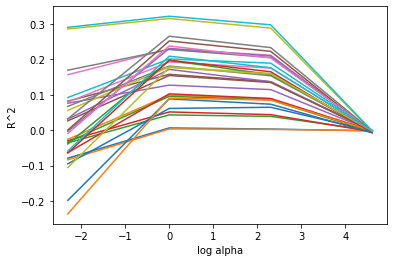

In [1409]:
for quarter in range (0,3):
    #Add in the previous quarter playing time, 
    G = pd.concat([G,Q[quarter][0], Q[quarter][1]], axis=1)
    #add previous quarter score.
    X = pd.concat([G, data_p.iloc[:,quarter*MAX_PY+SCORE_LOC+V_LOC],
                   data_p.iloc[:,quarter*MAX_PY+SCORE_LOC+HOME_LOC]],axis=1)
    linear_and_polynomial(quarter,X,train2[quarter],test2[quarter],
                          test_p2[quarter],lrfit2[quarter],smfit2[quarter],lr_p_fit2[quarter],poly_list2)

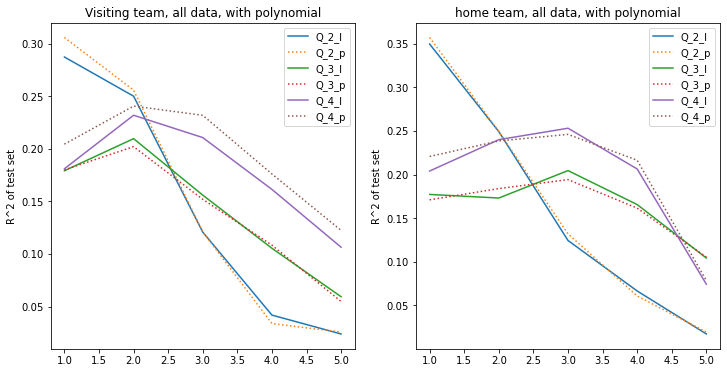

In [1410]:
plt.figure(figsize=([12,6]))
plt.subplot(1,2,1)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test2[i-2][0:MAX_OUT],label='Q_{}_l'.format(i))
    plt.plot(range(1,1+MAX_OUT),test_p2[i-2][0:MAX_OUT],label='Q_{}_p'.format(i), linestyle=':')
plt.ylabel('R^2 of test set')
plt.title("Visiting team, all data, with polynomial")
plt.legend()
plt.subplot(1,2,2)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test2[i-2][MAX_OUT:MAX_OUT*2],label='Q_{}_l'.format(i))
    plt.plot(range(1,1+MAX_OUT),test_p2[i-2][MAX_OUT:MAX_OUT*2],label='Q_{}_p'.format(i), linestyle=':')
plt.ylabel('R^2 of test set')
plt.title("home team, all data, with polynomial")
plt.legend()
plt.savefig('result_f.png',dpi=150,transparent=False);

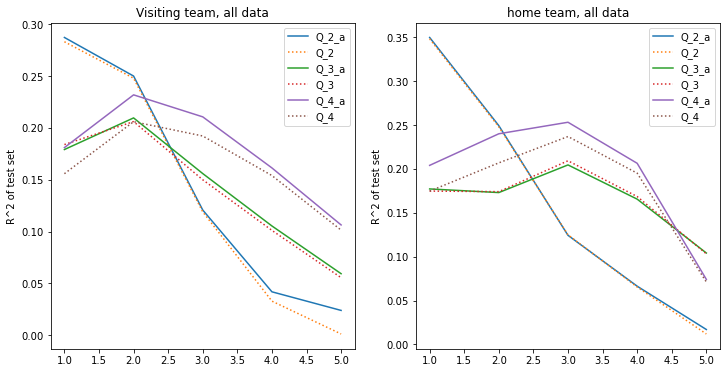

In [1411]:
plt.figure(figsize=([12,6]))
plt.subplot(1,2,1)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test2[i-2][0:MAX_OUT],label='Q_{}_a'.format(i))
    plt.plot(range(1,1+MAX_OUT),test[i-2][0:MAX_OUT],label='Q_{}'.format(i), linestyle=':')
plt.ylabel('R^2 of test set')
plt.title("Visiting team, all data")
plt.legend()
plt.subplot(1,2,2)
for i in range (2,5):
    plt.plot(range(1,1+MAX_OUT),test2[i-2][MAX_OUT:MAX_OUT*2],label='Q_{}_a'.format(i))
    plt.plot(range(1,1+MAX_OUT),test[i-2][MAX_OUT:MAX_OUT*2],label='Q_{}'.format(i), linestyle=':')
plt.ylabel('R^2 of test set')
plt.title("home team, all data")
plt.legend()
plt.savefig('result_c.png',dpi=150,transparent=False);

In [1415]:
test_p2

array([[0.30576349, 0.25566236, 0.12098168, 0.03375852, 0.02571743,
        0.35724357, 0.249351  , 0.13188917, 0.06065755, 0.0192421 ],
       [0.17990567, 0.20196927, 0.15190281, 0.10832576, 0.05478848,
        0.17096536, 0.18383702, 0.19413348, 0.16147637, 0.10521345],
       [0.20434883, 0.24051848, 0.23178315, 0.1760109 , 0.12239185,
        0.22071824, 0.23854362, 0.24604918, 0.21633352, 0.0783367 ]])

In [1414]:
test2

array([[0.28717674, 0.24995647, 0.12072146, 0.04184419, 0.02389784,
        0.34969097, 0.24921266, 0.12432569, 0.06637345, 0.01704017],
       [0.17907624, 0.20958158, 0.15588472, 0.10535342, 0.05931296,
        0.17714983, 0.17301731, 0.20450581, 0.16553899, 0.10416352],
       [0.18094872, 0.23182143, 0.21059934, 0.16133804, 0.10634853,
        0.20400845, 0.23999169, 0.25311465, 0.20635984, 0.07413691]])

R2 for test is: 0.1607043543334178
[ 31.65812241  32.14100023 -40.1128144   46.41581985  35.91981548
  27.45567577  25.69077882  25.2139725    8.14075405   6.99334342
   5.35505862  12.59874029  16.79803159  20.36965957  12.94884976
  12.96226627  -4.30641347  -8.97468434  -8.32929174 -14.62706107
   5.22380505 -16.29414925  -9.56285918 -13.42027891  -4.68771421
  -3.79875926  11.4781601  -11.82183664  -1.67899476  -0.35959861
 -13.2325051   -6.2398502    5.34263855   0.4651689   13.37772245
  -7.01264596   7.23202201  15.77757658   0.70772831  -0.16191741
 -14.19450925  -2.49555224  10.23839594   5.97704611  25.60140433
  19.42870025  20.21390698   2.68157398   6.62727493   0.3754156
   3.25575301 -10.44585375]


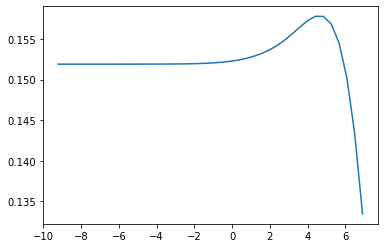

In [1058]:
grid_model(Ridge(),X_tr, y_train,kfold,std.transform(X_val.values),y_val)

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38449647.59867674, tolerance: 9791.019080559083
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34694730.437881514, tolerance: 9941.2752506565
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31525374.71690338, tolerance: 9729.730828831498
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/skl

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30520591.699300207, tolerance: 10000.66941714649
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31069908.371527284, tolerance: 9712.565378492804
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29901388.103955008, tolerance: 9791.019080559083
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3852989.9212462977, tolerance: 10000.66941714649
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4559742.9212718755, tolerance: 9712.565378492804
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4122265.7446202785, tolerance: 9791.019080559083
  model = cd_fast.enet_coordinate_descent(
/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages

R2 for test is: 0.1580285276372161
[ 31.26828012  30.7942877  -40.59742252  46.36593262  34.97117865
  26.5000371   24.83044208  23.54334083   5.32687198   4.00464965
   1.55891265   9.00828459  13.20207799  16.66843181   9.20078746
   8.40571636  -3.94405709  -0.          -0.         -12.47486038
  -0.          -5.51201135  -0.          -0.           0.
  -0.           3.59299438  -0.          -0.55351007  -1.55694803
  -6.90444363  -0.           3.97645004   0.           3.99438426
   0.           0.           3.8397065   -0.          -0.
  -7.7374016   -0.           0.          -0.          16.02507147
  13.14936969   6.44275325   2.87253861   0.65573605   0.
   1.62375342  -8.81884602]


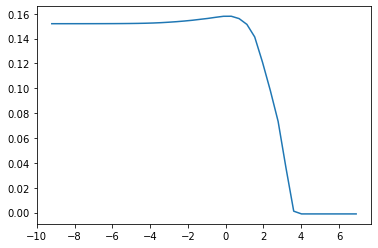

In [1059]:
grid_model(Lasso(),X_tr, y_train,kfold,std.transform(X_val.values),y_val)

In [1191]:
def grid_model(model,X_train, y_train,kfold,X_val,y_val):
    params = { "alpha": np.logspace(-3, 2, 20)}
    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                        return_train_score=False)
             #               scoring='neg_root_mean_squared_error')
    grid_est.fit(X_train, y_train)
    df = pd.DataFrame(grid_est.cv_results_)
    
    # bring out part of the column into a new column
    df["alpha"] = df.params.apply(lambda val: val["alpha"])
    plt.plot(np.log(df.alpha), df.mean_test_score);   
    lr_r=grid_est.best_estimator_
    lr_r.fit(X_train, y_train)
    test_set_pred = lr_r.predict(X_val)
    print("R2 for test is:",r2_score(y_val,test_set_pred))
    return lr_r      

In [1427]:
lr_r=lr_p_fit2[2][9]

In [1428]:
np.where(lr_r.coef_ != 0)

(array([  46,   48,   53,   54,   55,   67,   73,   82,   83,   88,   95,
         110,  112,  113,  129,  130,  131,  137,  151,  153,  165,  167,
         169,  171,  173,  174,  180,  193,  194,  196,  197,  201,  203,
         214,  215,  217,  219,  221,  223,  225,  240,  243,  246,  251,
         252,  254,  255,  256,  259,  260,  261,  268,  269,  273,  277,
         278,  283,  284,  288,  293,  295,  310,  311,  316,  317,  331,
         335,  339,  340,  341,  355,  360,  364,  367,  369,  386,  387,
         388,  390,  391,  396,  400,  402,  405,  421,  426,  427,  437,
         438,  440,  449,  451,  460,  463,  470,  476,  488,  492,  493,
         514,  518,  550,  552,  585,  600,  608,  620,  636,  643,  651,
         663,  674,  680,  681,  698,  700,  707,  716,  745,  746,  761,
         780,  781,  784,  793,  824,  839,  843,  855,  866,  867,  868,
         878,  880,  883,  887,  895,  897,  900,  908,  909,  910,  915,
         917,  918,  923,  930,  935, 

In [1430]:
a_poly=poly_list2[2]

In [1431]:
a=[ a_poly.get_feature_names()[x] for x in np.where(lr_r.coef_ != 0)[0] ]

In [1432]:
a

['x0 x2',
 'x0 x4',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x0 x23',
 'x0 x29',
 'x0 x38',
 'x0 x39',
 'x1^2',
 'x1 x8',
 'x1 x23',
 'x1 x25',
 'x1 x26',
 'x1 x42',
 'x1 x43',
 'x2^2',
 'x2 x8',
 'x2 x22',
 'x2 x24',
 'x2 x36',
 'x2 x38',
 'x2 x40',
 'x2 x42',
 'x3^2',
 'x3 x4',
 'x3 x10',
 'x3 x23',
 'x3 x24',
 'x3 x26',
 'x3 x27',
 'x3 x31',
 'x3 x33',
 'x4^2',
 'x4 x5',
 'x4 x7',
 'x4 x9',
 'x4 x11',
 'x4 x13',
 'x4 x15',
 'x4 x30',
 'x4 x33',
 'x4 x36',
 'x4 x41',
 'x4 x42',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x5 x10',
 'x5 x11',
 'x5 x12',
 'x5 x19',
 'x5 x20',
 'x5 x24',
 'x5 x28',
 'x5 x29',
 'x5 x34',
 'x5 x35',
 'x5 x39',
 'x6^2',
 'x6 x8',
 'x6 x23',
 'x6 x24',
 'x6 x29',
 'x6 x30',
 'x7^2',
 'x7 x11',
 'x7 x15',
 'x7 x16',
 'x7 x17',
 'x7 x31',
 'x7 x36',
 'x7 x40',
 'x7 x43',
 'x8 x9',
 'x8 x26',
 'x8 x27',
 'x8 x28',
 'x8 x30',
 'x8 x31',
 'x8 x36',
 'x8 x40',
 'x8 x42',
 'x9 x10',
 'x9 x26',
 'x9 x31',
 'x9 x32',
 'x9 x42',
 'x9 x43',
 'x10 x11',
 'x10 x20',
 'x10 x22',
 'x10 x31',


In [1433]:
lr_r.coef_[np.where(lr_r.coef_ != 0)]

array([  9.2972665 ,   4.33121165,   0.99848374,  -6.40565861,
        -5.94097233,  -2.15231509,   9.5408169 ,  -0.06775353,
        -0.13988785,  -2.03749309,  12.06219825,   0.67039978,
         7.76252141,  -0.45572307, -21.06102898,  20.31216531,
        -5.74237876,   1.98516747,   4.81614049,   4.23780646,
        -3.04604937,  14.87066685,   3.61741566, -26.97349376,
         8.15398057,  -9.06694708,   1.67616407,  10.37880185,
       -14.70355982,   0.28786745,  -3.60391675,  -1.02180803,
        -4.34516009,   2.57076152,  -3.60453812,   1.72410051,
         0.77772577,   0.36287378,  -5.23125359,  -7.42987136,
        -4.56661051,  -3.75345888,  -1.5684946 ,  12.17936397,
        10.99636435,   0.23942948,  -8.71928947,  -0.22719991,
         0.81757307,   1.64715793,   3.33658411,   9.23751524,
         0.17451395,  -1.0059729 ,  -2.9472116 ,  -6.17537329,
         4.22043755,  -8.75171521,   3.78876056,  -7.93788767,
        -8.74931512,  -3.53449033,   4.94687621,   2.93

In [1425]:
sm0=smfit2[2][9]

In [1434]:
sm0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    121   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     17.75
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          2.45e-118
Time:                        06:43:37   Log-Likelihood:                -19291.
No. Observations:                2952   AIC:                         3.867e+04
Df Residuals:                    2907   BIC:                         3.894e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        487.0478      3.091    157.582      0.000     480.987     493.108
x1            27.3740     55.333      0.495      0.621     -81.122     135.870
x2            12.1482      3.305      3.675      0.000       5.667      18.629
x3            -0.2466      3.263     -0.076      0.940      -6.645       6.152
x4            -6.2812      3.215     -1.954      0.051     -12.585       0.022
x5            -1.1221      3.143     -0.357      0.721      -7.284       5.040
x6            -4.6735      3.151     -1.483      0.138     -10.852       1.505
x7           -23.3235     55.313     -0.422      0.673    -131.780      85.133
x8             0.1658      3.278      0.051      0.960      -6.262       6.594
x9             1.7521      3.261      0.537      0.591      -4.642       8.146
x10           -4.1126      3.176     -1.295      0.195     -10.339       2.114
x11           -9.1226      3.171     -2.877      0.004     -15.341      -2.904
x12          -15.2985      3.145     -4.865      0.000     -21.464      -9.133
x13            5.0241      4.085      1.230      0.219      -2.985      13.034
x14           -2.9670      4.048     -0.733      0.464     -10.904       4.970
x15           -5.8279      3.673     -1.587      0.113     -13.029       1.373
x16           -6.8894      3.406     -2.023      0.043     -13.568      -0.211
x17           -1.4411      3.294     -0.437      0.662      -7.901       5.018
x18          -18.9002      4.145     -4.559      0.000     -27.028     -10.772
x19           26.4661      3.970      6.667      0.000      18.682      34.250
x20            2.1872      3.709      0.590      0.555      -5.085       9.459
x21            1.2204      3.490      0.350      0.727      -5.622       8.063
x22            4.1175      3.296      1.249      0.212      -2.346      10.581
x23            1.9191      3.988      0.481      0.630      -5.901       9.739
x24            0.8554      3.948      0.217      0.828      -6.885       8.596
x25           -1.9368      3.653     -0.530      0.596      -9.099       5.226
x26           -8.5109      3.394     -2.507      0.012     -15.167      -1.855
x27            2.4660      3.207      0.769      0.442      -3.822       8.754
x28           -0.7986      4.007     -0.199      0.842      -8.655       7.058
x29           32.0773      3.892      8.242      0.000      24.446      39.708
x30           13.2973      3.625      3.668      0.000       6.190      20.405
x31            2.7810      3.413      0.815      0.415      -3.910       9.473
x32           -1.8492      3.201     -0.578      0.563      -8.125       4.427
x33            5.4383      3.490      1.558      0.119      -1.404      12.280
x34            8.1133      3.570      2.272      0.023       1.113      15.114
x35           11.2846      3.550      3.179      0.001       4.323      18.246
x3

In [1416]:
player=0
y = data_p.iloc[:,HOME_LOC+(quarter+1)*MAX_PY+player+1]
X_tr = std.transform(X.values)

In [1419]:
X_tr.shape

(3690, 44)

In [1435]:
lm=lrfit2[2][9]
y_pred_l=lm.predict(X_tr)
print(r2_score(y,y_pred_l))

0.2091256222076019


In [1438]:
poly0=poly_list2[2]
X_poly=poly0.transform(X)
X_poly_fit=std_poly.transform(X_poly)
y_pred_p = lr_r.predict(X_poly_fit)
print(r2_score(y,y_pred_p))

0.29206092165274966


In [1439]:
y_p=pd.DataFrame({'y':y,'pred_l':y_pred_l,'pred_p':y_pred_p})

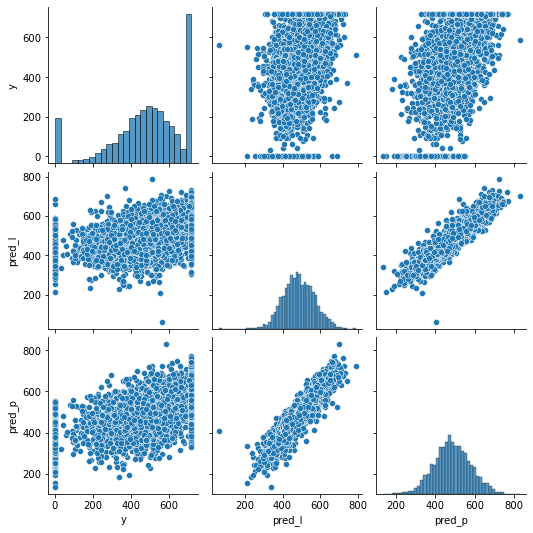

In [1441]:
sns.pairplot(y_p)
plt.savefig('pair.png');

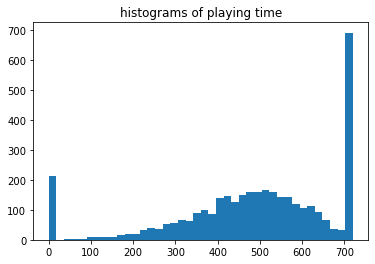

In [1442]:
plt.hist(y,bins=40)
plt.title('histograms of playing time')
plt.savefig('hist.png',dpi=150,transparent=False);

In [1356]:

   X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    std.fit(X_train.values)
    X_tr=std.transform(X_train.values)
    scores = cross_val_score(lr, X_tr, y_train, cv=kfold,scoring='neg_root_mean_squared_error')
    print(f"For quarter {quarter+2}, player {player}\n:")
    print("score using neg_root_mean_squared_error is {}\n, mean is {}, std is {}".
          format(scores,np.mean(scores),np.std(scores)))
    scores = cross_val_score(lr, X_tr, y_train, cv=kfold)
    train=np.mean(scores)
    print("score using R2 is {}, mean is {}, std is {}".format(scores,train,np.std(scores)))
    lr.fit(X_tr,y_train)

    # score fit model on validation data
    val_score = lr.score(std.transform(X_val.values), y_val)
    lrfit.append(lr)
    #Create the sm model
    model = sm.OLS(y_train, sm.add_constant(X_tr)) 
    smfit.append(model.fit())

,60,135,1,2,3,4,5,76,77,78,79,80
0,1,1,455,620,395,641,395,545,545,455,579,679
1,1,1,639,541,624,312,312,541,549,541,370,445
2,1,1,530,530,459,459,459,566,613,459,613,530
3,1,1,561,552,467,552,552,629,711,561,455,552
4,1,1,512,619,565,601,470,720,565,418,656,470
...,...,...,...,...,...,...,...,...,...,...,...,...
3685,82,82,570,674,426,450,450,512,450,588,450,380
3686,82,82,423,420,420,423,423,649,524,423,423,391
3687,82,82,598,502,502,566,404,502,546,511,598,502
3688,82,82,471,402,402,499,438,418,574,499,549,499


In [1444]:
rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
X_train=std.transform(X.values)
rf.fit(X_train, y)
y_pred = rf.predict(X_train)
print("Random Forest Regression:", r2_score(y, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y)
y_pred = gbm.predict(X_train)
print("Gradient Boosted Regression:", r2_score(y, y_pred))

Random Forest Regression: 0.17448345937904164
Gradient Boosted Regression: 0.32728412470144963


In [1458]:
#Start with games played 
G = pd.concat([data_p.iloc[:,60:69],data_p.iloc[:,135:144]], axis=1)
score_test=np.zeros([3,2])
score_train=np.zeros([3,2])
test_p_score=np.zeros([3,2])
lr_score=[]
sm_score=[]
lr_p_score=[]

In [1468]:
test_p_score

array([[0.        , 0.03324003],
       [0.        , 0.        ],
       [0.        , 0.        ]])

For quarter 4, player 0
:
score using R2 is 0.047765149931802586
R2 for test is: 0.038744331429720114
For quarter 4, player 0
:
score using R2 is 0.041026806702189056
R2 for test is: 0.012319550569368287


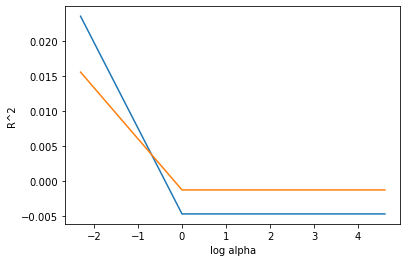

In [1480]:
for quarter in range (0,3):
    #Add in the previous quarter playing time, and previous quarter score.
    G = pd.concat([G,Q[quarter][0], Q[quarter][1], data_p.iloc[:,quarter*MAX_PY+SCORE_LOC+V_LOC],
                   data_p.iloc[:,quarter*MAX_PY+SCORE_LOC+HOME_LOC], ],axis=1)
    yp=data_p.iloc[:,q4h_score]   
    polyp = PolynomialFeatures(include_bias=False)
    stdp = StandardScaler()
    X = G     
    score_train[quarter][0], score_test[quarter][0]=linear_fit(0,X,yp, stdp,kfold,lr_score,sm_score)
    test_p_score[quarter][0]=poly_grid(X,yp,kfold,polyp,lr_p_score)
    yp=data_p.iloc[:,q4v_score]
    score_train[quarter][1], score_test[quarter][1]=linear_fit(0,X,yp, stdp,kfold,lr_score,sm_score)
    test_p_score[quarter][1]=poly_grid(X,yp,kfold,polyp,lr_p_score)

In [1481]:
sm_s=sm_score[4]

In [1482]:
sm_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    120   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.354
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           4.90e-15
Time:                        08:19:56   Log-Likelihood:                -9278.9
No. Observations:                2952   AIC:                         1.867e+04
Df Residuals:                    2897   BIC:                         1.900e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.4055      0.104    253.398      0.000      26.201      26.610
x1             2.2564      1.876      1.203      0.229      -1.421       5.934
x2            -0.3918      0.114     -3.438      0.001      -0.615      -0.168
x3            -0.0276      0.111     -0.247      0.805      -0.246       0.191
x4            -0.0990      0.109     -0.908      0.364      -0.313       0.115
x5            -0.2207      0.107     -2.069      0.039      -0.430      -0.012
x6            -0.2357      0.107     -2.209      0.027      -0.445      -0.027
x7             0.1151      0.110      1.047      0.295      -0.100       0.331
x8            -0.0912      0.108     -0.844      0.399      -0.303       0.121
x9             0.0356      0.107      0.331      0.741      -0.175       0.246
x10           -1.9965      1.875     -1.065      0.287      -5.673       1.680
x11            0.3211      0.114      2.828      0.005       0.098       0.544
x12            0.1503      0.111      1.355      0.175      -0.067       0.368
x13            0.0408      0.108      0.379      0.705      -0.170       0.252
x14            0.2370      0.107      2.207      0.027       0.026       0.448
x15            0.1277      0.107      1.197      0.232      -0.082       0.337
x16           -0.0239      0.109     -0.219      0.827      -0.239       0.191
x17           -0.0016      0.108     -0.014      0.988      -0.213       0.210
x18           -0.0551      0.107     -0.513      0.608      -0.265       0.155
x19           -0.0648      0.138     -0.469      0.639      -0.336       0.206
x20           -0.0438      0.137     -0.319      0.749      -0.313       0.225
x21           -0.1330      0.125     -1.063      0.288      -0.378       0.112
x22            0.0169      0.115      0.147      0.883      -0.209       0.242
x23            0.0516      0.112      0.463      0.644      -0.167       0.270
x24           -0.1612      0.140     -1.150      0.250      -0.436       0.114
x25           -0.0218      0.134     -0.163      0.871      -0.285       0.241
x26           -0.0635      0.125     -0.507      0.613      -0.309       0.182
x27            0.0083      0.118      0.070      0.944      -0.224       0.241
x28           -0.0693      0.111     -0.622      0.534      -0.288       0.149
x29            0.5510      0.110      4.990      0.000       0.334       0.767
x30           -0.3110      0.109     -2.846      0.004      -0.525      -0.097
x31           -0.1640      0.135     -1.213      0.225      -0.429       0.101
x32            0.1248      0.134      0.933      0.351      -0.138       0.387
x33            0.0659      0.124      0.534      0.594      -0.176       0.308
x34            0.0483      0.115      0.421      0.674      -0.177       0.273
x35           -0.0209      0.109     -0.192      0.848      -0.234       0.192
x3

In [1483]:
lr_score[4].coef_

array([ 1.42486527e-01, -3.25276270e-01, -0.00000000e+00, -0.00000000e+00,
       -1.16413041e-01, -1.15325856e-01,  2.94559455e-04, -5.63034420e-03,
        0.00000000e+00,  0.00000000e+00,  2.06381850e-01,  3.13078294e-02,
        0.00000000e+00,  1.41623725e-01,  3.22359129e-03,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -1.47464727e-02,
       -7.29066003e-02, -0.00000000e+00,  0.00000000e+00, -9.58286520e-02,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        4.03509636e-01, -1.90702239e-01, -1.72543047e-02,  1.54267256e-02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        4.65261651e-02, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.60449311e-01, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -1.90672872e-01,  0.00000000e+00,  0.00000000e+00, -4.93475309e-02,
       -4.37553221e-02, -0.00000000e+00,  0.00000000e+00, -1.40072121e-02,
        6.89538123e-01, -

In [1484]:
lr_score[5].coef_

array([ 0.        ,  0.        ,  0.        , -0.        ,  0.03483909,
        0.        ,  0.06347116,  0.        , -0.05585515,  0.08221715,
       -0.        , -0.13229921, -0.04464141, -0.21725738, -0.08483681,
       -0.        ,  0.        , -0.        , -0.07018571, -0.        ,
        0.05896165,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.03262003,  0.0283444 , -0.07758542,  0.23897791,
        0.        ,  0.        ,  0.        , -0.07597469,  0.        ,
        0.        , -0.01546151,  0.01940623,  0.        , -0.        ,
       -0.07906137,  0.3834251 , -0.2023339 , -0.        , -0.05407214,
        0.        , -0.        ,  0.        ,  0.03770604, -0.16760825,
       -0.01067011,  0.11523589,  0.0099181 ,  0.66716197])

In [1472]:
lr_p_score[1].coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.10528275,  0.        ,  0.        ,  0.        , -0.  